# Assemble Network Data
## Objective
Using datasets obtained from Geoscience Australia (GA) [1, 2, 3] and the Australian Bureau of Statistics (ABS) [4, 5], develop an approximate representation of the transmission grid comprising Australia's National Electricity Market (NEM).

## Approach
The steps taken to model the NEM are as follows:
1. Import packages and declare variables.
2. Parse raw kml data from GA and store the results in GeoPandas GeoDataFrames.
4. Filter features in the network:
   * Only consider 'Operational' network components;
   * filter elements by state (e.g. only consider elements in the NEM);
   * filter transmission lines by voltage level;
5. Following GA's definition of transmission lines, treat ends of transmission lines as nodes. Remove those at duplicated coordinates. Rename nodes using the format "n_##" (e.g. n_1, n_2, etc.).
6. Assign NEM Region and NEM Zone codes to each node using ABS state and territory boundary data.
6. Check for disonnected components:
   * remove nodes and lines which are disconnected from the greater network.
7. Assign network elements to nodes based on proximity.
   * for each network element (substation or power station) compute the haversine distance between it and all nodes. Return the closest node.
8. Find node IDs corresponding to:
   * Regional Reference Nodes (RRNs) within the NEM;
   * the start and end points of AC interconnectors;
   * the start and end points of HVDC links.
9. Compute electrical properties for AC tranmssions lines.
10. Allocate demand to nodes using ABS population data.
13. Write data to files.

## Import packages and declare variables
### Import packages

In [1]:
# Used to navigate directories, extract data, and save files
import os
import re
import pickle
import kml2geojson

# Used for data analysis
import random
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, LineString, MultiPolygon
from shapely.geometry.polygon import Polygon
from shapely.ops import nearest_points
import geopandas as gp
from scipy.sparse.csgraph import connected_components
from math import sin, cos, sqrt, atan2, radians, asin, pi, log, log10
from scipy.spatial import Voronoi, voronoi_plot_2d
from voronoi_util.voronoi_util.finite_polygons import voronoi_finite_polygons_2d

# Used for plotting and visualisation
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from IPython.core.display import display
from IPython.core.display import HTML

### Declare paths to folders and files

In [2]:
# Core data directory
data_dir = os.path.abspath(os.path.join(os.path.curdir, os.pardir, os.pardir, 'data'))

# Transmission line data path
lines_path = os.path.join(data_dir, 'Geoscience_Australia', 'ElectricityTransmissionLines_v2', 'doc.kml')

# Substation data path
substations_path = os.path.join(data_dir, 'Geoscience_Australia', 'ElectricityTransmissionSubstations_v2', 'doc.kml')

# Power station data path
power_stations_path = os.path.join(data_dir, 'Geoscience_Australia', 'MajorPowerStations_v2', 'doc.kml')

# Directory for output files
output_dir = os.path.abspath(os.path.join(os.path.curdir, 'output'))

## Parse network data
Steps:
1. Convert Geoscience Australia KML files to geojson format.
2. Read geojson files into GeoDataFrames. Set the coordinate reference system for each dataframe.
3. Format data and convert data types for columns containing numeric data.
4. Create unique IDs for each network element.

In [3]:
# Convert from KML to geojson
kml2geojson.main.convert(lines_path, os.path.join(output_dir, 'kml_to_geojson/lines'))
kml2geojson.main.convert(substations_path, os.path.join(output_dir, 'kml_to_geojson/substations'))
kml2geojson.main.convert(power_stations_path, os.path.join(output_dir, 'kml_to_geojson/power_stations'))

# Import geojson data into GeoPandas GeoDataFrames
gdf_l = gp.read_file(os.path.join(output_dir, 'kml_to_geojson', 'lines', 'doc.geojson'))
gdf_s = gp.read_file(os.path.join(output_dir, 'kml_to_geojson', 'substations', 'doc.geojson'))
gdf_p = gp.read_file(os.path.join(output_dir, 'kml_to_geojson', 'power_stations', 'doc.geojson'))

# Set coordinate reference system for each GeoDataFrame
gdf_p = gp.GeoDataFrame(gdf_p, crs={'init' :'epsg:4283'})
gdf_s = gp.GeoDataFrame(gdf_s, crs={'init' :'epsg:4283'})
gdf_l = gp.GeoDataFrame(gdf_l, crs={'init' :'epsg:4283'})

# Convert columns to numeric type
gdf_p['GENERATIONMW'] = pd.to_numeric(gdf_p['GENERATIONMW'])
gdf_l['CAPACITYKV'] = pd.to_numeric(gdf_l['CAPACITYKV'])

# List of tuples (containing floats) describing line path. Easier for data processing steps later on.
gdf_l['COORDINATES'] = gdf_l['geometry'].map(lambda x: [i for i in zip(x.xy[0], x.xy[1])])
gdf_s['COORDINATES'] = gdf_s['geometry'].map(lambda x: [(x.xy[0][0], x.xy[1][0])])
gdf_p['COORDINATES'] = gdf_p['geometry'].map(lambda x: [(x.xy[0][0], x.xy[1][0])])

# Assign element IDs based on placemark IDs
gdf_l.index = gdf_l['id'].str.findall('\d+').map(lambda x: '_'.join(['l', str(x[0])]))
gdf_l.index.name = 'LINE_ID'

gdf_s.index = gdf_s['id'].str.findall('\d+').map(lambda x: '_'.join(['s', str(x[0])]))
gdf_s.index.name = 'SUBSTATION_ID'

gdf_p.index = gdf_p['id'].str.findall('\d+').map(lambda x: '_'.join(['p', str(x[0])]))
gdf_p.index.name = 'POWER_STATION_ID'

## Filter network features
Only operational transmission lines, substations, and power stations are considered. Power stations with nameplate ratings less than 5MW are excluded, as AEMO allows these small plant to receive a standing exemption, preventing them from being classified as generators. As this analysis is focused on the tranmission network, low voltage lines (less than 100 kV) are also removed from the dataset. Elements are also filtered by the state in which they are located, with network elements in non-NEM states / territories (e.g. Western Australia and the Northern Territory) removed.

In [4]:
# Only keep operational elements
gdf_l = gdf_l[gdf_l.OPERATIONALSTATUS == 'Operational']
gdf_s = gdf_s[gdf_s.OPERATIONALSTATUS == 'Operational']
gdf_p = gdf_p[gdf_p.OPERATIONALSTATUS == 'Operational']

# Only consider generators with ratings greater than 5MW.
gdf_p = gdf_p[gdf_p['GENERATIONMW'] > 5]

# Only consider transmission lines with voltages greater than 100 kV
gdf_l = gdf_l[gdf_l['CAPACITYKV'] >= 100]

# Filter elements by the state in which they are located.
included_states = ['South Australia', 'Victoria', 'New South Wales', 'Tasmania', 'Queensland', 'Australian Capital Territory',
                   #'Northern Territory', 'Western Australia',
                  ]

gdf_l = gdf_l[gdf_l['STATE'].isin(included_states)]
gdf_s = gdf_s[gdf_s['STATE'].isin(included_states)]
gdf_p = gdf_p[gdf_p['STATE'].isin(included_states)]

## Create set of nodes

Metadata accompanying the transmission lines dataset states that:

> "Transmission lines are unbroken from end-point to end-point; where end-points coincide with and are snapped to the location of a substation or power station."

Based on this definition, the ends of transmission lines are treated as nodes within the network. Network elements (such as power stations or substations) will then be assigned to these nodes based on proximity.

### Assigning NEM region codes and NEM zones to nodes
State names and NEM region codes are assigned to nodes in order facilitate useful aggregation operations. Shapefiles describing the geographic boundaries of Australian states and territories are used to perform spatial join operations - yielding the state in which each node is located. NEM regions can generally be thought of as representing states within Australia (with NSW and the ACT aggregated). Boundaries at a more disaggregated level are given by NEM planning zones which are used in AEMO's own market models [6]. No data is available that explicilty defines the locations of these zones, however an illustration of these zones is given in [6]. The diagram in this document was compared to a map of network elements created from GA's datasets. Using high voltage transmission lines as a common reference, lines of demarcation between zones were approximated, allowing polygons defining NEM zones to be constructed. To avoid cluttering this notebook with long lists of coordinates, the procedure to construct each NEM zone is defined within a separate script, and can be found in the 'nem_zones' sub-directory within the folder containing this notebook. The output of this script is a pickled GeoDataFrame describing the approximate boundaries of each NEM planning zone, with these boundaries plotted below.

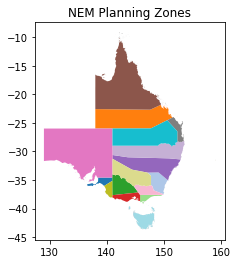

In [5]:
# Create set of nodes
# -------------------
# Set of all nodes based on the ends of transmission lines
n = set(gdf_l['geometry'].boundary.map(lambda x: (float(x[0].x), float(x[0].y)))) | set(gdf_l['geometry'].boundary.map(lambda x: (float(x[1].x), float(x[1].y))))

# Dataframe containing nodes
gdf_n = gp.GeoDataFrame(data={'COORDINATES':list(n)}, index=[int(i + 1) for i in range(len(n))], crs={'init' :'epsg:4283'})

# Convert coordinates to a shapely point object
gdf_n['geometry'] = gdf_n['COORDINATES'].map(lambda x: Point(x))


# Assign states, NEM region codes, and NEM zones to nodes
# -------------------------------------------------------
# Data describing state and territory boundaries in Australia
gdf_states = gp.GeoDataFrame.from_file(os.path.join(data_dir, 'ABS', '1259030002_ste06aaust_shape', 'STE06aAUST.shp'))

# Assign state name to each node
gdf_n = gp.sjoin(gdf_n, gdf_states[['STATE_NAME', 'geometry']], how='left', op='within').drop('index_right', axis=1)

# Assign NEM region code based on state name (NSW and ACT are aggregated)
nem_regions = {'South Australia': 'SA1', 'Victoria': 'VIC1', 'New South Wales': 'NSW1', 
              'Australian Capital Territory': 'NSW1', 'Tasmania': 'TAS1', 'Queensland': 'QLD1'}
gdf_n['NEM_REGION'] = gdf_n['STATE_NAME'].map(lambda x: nem_regions[x])

# NEM zones
with open('nem_zones/gdf_nem_zones.pickle', 'rb') as f:
    gdf_nem_zones = pickle.load(f)
gdf_nem_zones.index.name = 'NEM_ZONE'
gdf_nem_zones.crs = {'init': 'epsg:4283'}

# Plot NEM zones
plt.clf()
gdf_nem_zones.plot(cmap='tab20')
plt.title('NEM Planning Zones')
plt.show()

# Assign NEM zone to nodes
gdf_n = gp.sjoin(gdf_n, gdf_nem_zones.reset_index()[['NEM_ZONE', 'geometry']], how='left', op='within').drop('index_right', axis=1)
gdf_n.index.name = 'NODE_ID'

Having created a geodataframe describing nodes within the network, 'from' and 'to' nodes are assigned to each line. The first coordinate describing a line's path is the 'from' node, and the last coordinate in a line's path is the 'to' node.

In [6]:
# Assign 'from' and 'to' nodes to each line. 
gdf_l['FROM_NODE'] = gdf_l['geometry'].boundary.map(lambda x: gdf_n.loc[gdf_n['COORDINATES'] == (x[0].x, x[0].y)].index[0])
gdf_l['TO_NODE'] = gdf_l['geometry'].boundary.map(lambda x: gdf_n.loc[gdf_n['COORDINATES'] == (x[1].x, x[1].y)].index[0])

The voltage level of a node can be inferred by examing the transmission lines connected to it. The function below finds the voltage levels of all lines connected to a node, returning the maximum value (the minimum value could have also been chosen here). Note that GA's transmission line dataset provides line-to-line voltages. These values will be used at a later stage of the analysis to compute base impedances for lines. In other network representations line-to-line voltages are generally deduced from node voltages - here such a procedure is unnecessary as these values are given directly. The nodal voltages provided in this analysis are only intended to serve as a reference, and can provide a useful means by which to aggregate nodes if needed.

In [7]:
def get_node_voltage(row):
    """Get node voltage"""
    
    mask = (gdf_l['FROM_NODE'] == row.name) | (gdf_l['TO_NODE'] == row.name)
    return gdf_l.loc[mask, 'CAPACITYKV'].values.max()

gdf_n['VOLTAGE_KV'] = gdf_n.apply(get_node_voltage, axis=1)

## Check for disconnected components
The connectedness of the network is now checked. Disconnected lines and components are removed. The number of nodes and transmission lines in the dataset prior to checking for disconnected components is given below.

In [8]:
print('Transmission lines:', len(gdf_l))
print('Nodes:', len(gdf_n))

Transmission lines: 1685
Nodes: 960


Construct adjacency DataFrame describing relationships between connected nodes.

In [9]:
def get_adjacency_dataframe(gdf_l, gdf_n):
    """
    Find the adjacency matrix describing connections between 
    nodes in the network (AKA ends of transmission lines)

    Parameters
    ----------
    gdf_l : pandas dataframe
        Transmission line data
    gdf_n : pandas dataframe
        Nodes in the network

    Returns
    -------
    df_adj : pandas dataframe
        Adjacency matrix in the form of a pandas dataframe.

    Notes
    -----
    Row and column labels are the same. A '1' at row i, column j implies
    that nodes i and j are connected by a line. By symmetry row j and column i
    will also have an entry of 1. Diagonal elements are also set to 1. An entry
    of 0 indicates no connection between nodes i and j.
    """

    # Adjacency matrix for all nodes
    df_adj = pd.DataFrame(data=0, index=gdf_n.index, columns=gdf_n.index)

    for i in range(len(gdf_l)):
        # FROM node ID
        r = gdf_l.iloc[i]['FROM_NODE']

        # TO node ID
        c = gdf_l.iloc[i]['TO_NODE']

        # Finding corresponding indicies based on node IDs
        df_adj.loc[r][c] = 1
        df_adj.loc[c][r] = 1
        df_adj.loc[r][r] = 1
        df_adj.loc[c][c] = 1

    return df_adj

df_adj = get_adjacency_dataframe(gdf_l, gdf_n)

Disconnected or isolated nodes are then identified. This is accomplished by using the `connected_components` method within the ScipPy package.

In [10]:
def get_disconnected_nodes(df_adj):
    """
    Find disconnected nodes within the network.
    
    Parameters
    ----------
    df_adj : pandas dataframe
        Adjacency matrix for the network
    
    Returns
    -------
    discon_node_IDs : list
        List of node IDs that are disconnected from the greater network
    """
    
    # Array with disconnected components
    discon_array = connected_components(np.array(df_adj))
    
    # Indices of disconnected components
    discon_node_indices, = np.where(discon_array[1] > 0)
    
    # IDs of disconnected nodes
    discon_node_IDs = list(df_adj.iloc[discon_node_indices].index)

    return discon_node_IDs

# Nodes disconnected from the greater network
discon_node_IDs = get_disconnected_nodes(df_adj)

# Mark whether lines are connected (with 'True') or disconnected ('False') from the greater network
# Note: If a node is disconnected, then the line(s) to which it is connected must also be disconnected.
gdf_l['CONNECTED'] = ~(gdf_l['FROM_NODE'].isin(discon_node_IDs) | gdf_l['TO_NODE'].isin(discon_node_IDs))

# All nodes in the connected network
con_nodes = (set(gdf_l.loc[gdf_l['CONNECTED'] == True, 'FROM_NODE']) | set(gdf_l.loc[gdf_l['CONNECTED'] == True, 'TO_NODE']))

# Column indicates whether node is in the connected network
gdf_n['CONNECTED'] = False
gdf_n.loc[con_nodes, 'CONNECTED'] = True

# Print number of transmission lines and nodes remaining in the connected network
print('Remaining transmission lines in the connected network:', len(gdf_l[gdf_l['CONNECTED'] == True]))
print('Remaining nodes in the connected network:', len(gdf_n[gdf_n['CONNECTED'] == True]))

# Show transmission lines GeoDataFrame
gdf_l

Remaining transmission lines in the connected network: 1656
Remaining nodes in the connected network: 912


,id,name,description,styleUrl,OBJECTID,FEATURETYPE,DESCRIPTON,CLASS,FID,OPERATIONALSTATUS,...,STATE,SPATIALCONFIDENCE,REVISED,SHAPE_Length,COMMENT,geometry,COORDINATES,FROM_NODE,TO_NODE,CONNECTED
LINE_ID,,,,,,,,,,,,,,,,,,,,,
l_1,kml_1,Callide B Power Station to Calvale,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,1,Transmission Line,A network of wires and insulators used to conn...,Overhead,1,Operational,...,Queensland,5,20120710,0.0101670994252775,None,"LINESTRING Z (150.619749 -24.3448799999999 0, ...","[(150.619749, -24.3448799999999), (150.6202328...",931,930,True
l_2,kml_2,Callide B Power Station to Calvale,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,2,Transmission Line,A network of wires and insulators used to conn...,Overhead,2,Operational,...,Queensland,5,20120710,0.0112400629710936,None,"LINESTRING Z (150.6274575 -24.3426034999999 0,...","[(150.6274575, -24.3426034999999), (150.626168...",930,931,True
l_3,kml_3,Calvale to Callide A Power Station,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,3,Transmission Line,A network of wires and insulators used to conn...,Overhead,3,Operational,...,Queensland,5,20120710,0.00930362099296361,None,"LINESTRING Z (150.628405 -24.3343189999999 0, ...","[(150.628405, -24.3343189999999), (150.6287240...",928,930,True
l_4,kml_4,Braemar to Bulli Creek,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,4,Transmission Line,A network of wires and insulators used to conn...,Overhead,4,Operational,...,Queensland,5,20120710,0.83019401119138,None,LINESTRING Z (150.843106929 -27.9211175899999 ...,"[(150.843106929, -27.9211175899999), (150.8426...",659,660,True
l_5,kml_5,Moura to Biloela Tee,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,5,Transmission Line,A network of wires and insulators used to conn...,Overhead,5,Operational,...,Queensland,5,20120710,0.466893010739631,None,"LINESTRING Z (150.502034221 -24.386390138 0, 1...","[(150.502034221, -24.386390138), (150.49946779...",929,932,True
l_6,kml_6,Baralaba to Moura,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,6,Transmission Line,A network of wires and insulators used to conn...,Overhead,6,Operational,...,Queensland,5,20120710,0.382421069357929,None,LINESTRING Z (150.065439636 -24.5138434739999 ...,"[(150.065439636, -24.5138434739999), (150.0651...",932,761,True
l_7,kml_7,Warwick to Stanthorpe,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,7,Transmission Line,A network of wires and insulators used to conn...,Overhead,7,Operational,...,Queensland,5,20120710,0.580243017927281,None,"LINESTRING Z (151.916848 -28.6453205 0, 151.91...","[(151.916848, -28.6453205), (151.917452692, -2...",872,831,True
l_8,kml_8,Callide C Power Station to Calvale,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,8,Transmission Line,A network of wires and insulators used to conn...,Overhead,8,Operational,...,Queensland,5,20120710,0.0129457385363591,None,"LINESTRING Z (150.618181 -24.3449459999999 0, ...","[(150.618181, -24.3449459999999), (150.6177534...",933,930,True
l_9,kml_9,South Toowoomba Tee to Kearneys Spring,<center><table><tr><th colspan='2' align='cent...,#KMLStyler,9,Transmission Line,A network of wires and insulators used to conn...,Overhead,9,Operational,...,Queensland,5,20120710,0.0328021084140832,None,"LINESTRING Z (151.938155 -27.6134135 0, 151.93...","[(151.938155, -27.6134135), (151.93855159, -27...",557,554,True


## Assign network elements to nodes
For each substation and power station, find the closest node (nearest end of a transmission line).

In [11]:
def haversine_formula(coord1, coord2):
    """
    Haversine formula used to find distance between two longitude and latitude coordinates.

    Parameters
    ----------
    coord1 : tuple OR list containing a single tuple
        The longitude-latitude coordinates for a point (in decimal degrees).
    coord2 : tuple OR list containing a single tuple
        The longitude-latitude coordinates for a point (in decimal degrees).
        
    Methods
    -------
    _parse_coordinate(coord)
        Extracts tuple from list if necessary, and converts lon-lat coordinates
        to radians.

    Returns
    -------
    distance : float
        Distance in kilometers between two coordinates.
    """

    def _parse_coordinate(coord):
        """
        Parse coordinates and convert to radians.
        
        Parameters
        ----------
        coord : tuple OR list containing a single tuple
            A lon-lat tuple (lon, lat) either by itself or
            contained within a list (e.g. [(lon, lat)])
        
        Returns
        -------
        (coordLon, coordLat) : tuple
            Tuple with the lon-lat coordinates converted to
            radians.
        
        Notes
        -----
        This method is needed because tuples in the dataframes are sometimes 
        contained within lists e.g. [(lon, lat)]. The method extracts the lon
        and lat irrespective of whether the tuple is in a list or not.
        """
        
        # Check if coordinate is within a list and extract if necessary
        if type(coord) is list:
            if len(coord) > 1:
                raise Warning('Can only accept a single tuple. More than one provided.')
            coordLon, coordLat = coord[0]
        else:
            coordLon, coordLat = coord
        
        # Convert to radians
        coordLon = radians(coordLon)
        coordLat = radians(coordLat)
        
        return coordLon, coordLat
    
    # Parse coordinates
    coord1Lon, coord1Lat = _parse_coordinate(coord1)
    coord2Lon, coord2Lat = _parse_coordinate(coord2)

    # Latitude and longitude difference between points
    dlon = coord2Lon - coord1Lon
    dlat = coord2Lat - coord1Lat

    # Approximate circumference of Earth [km]
    R = 6373
    
    # Apply haversine formula
    a = sin(dlat/2)**2 + cos(coord1Lat) * cos(coord2Lat) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a),sqrt(1-a))
    
    # Distance between two coordinates in kilometers
    distance = R*c

    return distance

def get_closest_node(row, gdf_n, haversine_formula):
    """
    Find closest node given a particular coordinate.
    
    Parameters
    ----------
    row : pandas object
        Contains the geographic lon-lat coordinates.
    
    df_n : pandas dataframe
        Pandas dataframe containing the locations of all virtual nodes (ends of transmission lines).
    
    Methods
    -------
    haversine_formula
        Computes the distance between two lon-lat coordinates in kilometres.
    
    Returns
    -------
    n_allocation : pandas series
        The ID of the closest node and the distance to it.  
    """
    
    # Dataframe which will contain distance between a particular network element and all nodes (in km).
    df_diff = pd.DataFrame()
    
    # Coordinates of the nodes
    df_diff['COORDINATES'] = gdf_n['COORDINATES']
    
    
    # Compute distance between a coordinate and nodes
    df_diff['DISTANCE'] = df_diff['COORDINATES'].map(lambda coord: haversine_formula((row.x, row.y), coord))

    # Node with the minimimum distance to the network element is selected
    n_allocation = pd.Series([df_diff['DISTANCE'].idxmin(), df_diff['DISTANCE'].min()], 
                             index=['NODE', 'NODE_DISTANCE'])
    return n_allocation

# For each substation, find the closest node in the connected network
gdf_s[['NEAREST_NODE', 'NEAREST_NODE_DISTANCE_KM']] = gdf_s['geometry'].apply(get_closest_node, args=(gdf_n.loc[gdf_n['CONNECTED'] == True], haversine_formula,))

# For each power station, find the closest node in the connected network
gdf_p[['NEAREST_NODE', 'NEAREST_NODE_DISTANCE_KM']] = gdf_p['geometry'].apply(get_closest_node, args=(gdf_n.loc[gdf_n['CONNECTED'] == True], haversine_formula,))

# Convert node ID to type int
gdf_s['NEAREST_NODE'] = gdf_s['NEAREST_NODE'].astype(int)
gdf_p['NEAREST_NODE'] = gdf_p['NEAREST_NODE'].astype(int)

Define a cut-off distance that signals whether a network element is too far from its assigned node. Here the cut-off is defined to be 100km.

In [12]:
# Column to identify which elements are still in the connected network
gdf_s['CONNECTED'] = True
gdf_p['CONNECTED'] = True

# If distance from nearest node is >  X km, element is said to be no longer in the network
cutoff_distance = 100
gdf_s.loc[gdf_s['NEAREST_NODE_DISTANCE_KM'] > cutoff_distance, 'CONNECTED'] = False
gdf_p.loc[gdf_p['NEAREST_NODE_DISTANCE_KM'] > cutoff_distance, 'CONNECTED'] = False

Compute the lengths of each line.

In [13]:
def get_line_length(line, harversine_formula):
    """
    Find length of a transmission line (in kilometres).

    Parameters
    ----------
    line : list of tuples
        List containing tuples defining the coordinates of the transmission
        line's path. E.g. [(lon1, lat1),(lon2, lat2),...]

    Returns
    -------
    line_length : float
        Length of line in kilometres

    Notes
    -----
    The haversine formula is used to calculate distances between adjacent coordinates.
    Summing the distances between adjacent coordinates gives the total length of the line.
    """
    
    # Initialise line length to zero
    line_length = 0

    # Loop through tuples defining a transmission line's path
    for i in list(range(len(line) - 1)):
        
        # Calculate distance between adjacent coordinates and update line_length
        line_length = line_length + haversine_formula(line[i], line[i + 1])

    return line_length

# Find length of each line (in kilometres)
gdf_l['LINE_LENGTH_KM'] = gdf_l['COORDINATES'].apply(get_line_length, args=(haversine_formula,))

### Regional Reference Nodes (RRNs)
AEMO assigns each NEM region a RRN. It is at these nodes at which Regional Reference Prices (RRPs) are reported. These nodes, and their corresponding placemark IDs within the Geosience Australia substations dataset are shown below.

| State | Node | Placemark ID | Dataset|
| ----- | ---- | ------------ | -------|
|QLD | South Pine 275kV | kml_720 | substations|
|NSW | Sydney West 330kV | kml_546 | substations|
|VIC |Thomastown 66kV | kml_554 | substations|
|SA | Torrens Island PS 66kV | kml_271 | substations|
|TAS | George Town 220 kV | kml_208 | substations|

In [14]:
# Function used to lookup node IDs based on Geoscience Australia datasets
def get_node_id(placemark_id, point_type):
    """Lookup node ID corresponding a placemark ID in the original dataset
    
    Parameters
    ----------
    placemark_id : str
        ID of record in the original Geoscience Australia datasets
    point_type : str
        Used to filter records by type (either substation or power station).
        Use the prepended letter corresponding to either type.
    
    Returns
    -------
    node_id : str
        Node ID corresponding to the placemark ID within the datasets
    """
    
    if point_type not in ['s', 'p']:
        raise Exception("Point type must be either 's' (denoting substations) or 'p' (denoting) power stations")
    
    # Place all substations and power stations into a single geodataframe
    gdf_sp = gdf_s.append(gdf_p)
    
    # Filter either substations or power stations
    mask = gdf_sp.index.str.startswith(point_type)
    
    # Lookup node corresponding to placemark ID in the filtered dataframe
    node_id = gdf_sp[mask].set_index('id').loc[placemark_id, 'NEAREST_NODE']
    
    return int(node_id)

# Placemark IDs corresponding to NEM Regional Reference Nodes (RRNs)
RRN = [('QLD1', 'kml_720'), ('NSW1', 'kml_546'), ('VIC1', 'kml_554'), ('SA1', 'kml_271'), ('TAS1', 'kml_208')]

# Indicates if node is a Regional Reference Node (1=is a RRN, 0=not a RRN)
gdf_n['RRN'] = 0
for i in RRN:
    gdf_n.loc[get_node_id(i[1], 's'), 'RRN'] = 1
gdf_n.head()

,COORDINATES,geometry,STATE_NAME,NEM_REGION,NEM_ZONE,VOLTAGE_KV,CONNECTED,RRN
NODE_ID,,,,,,,,
1,"(152.299799, -24.9171415)",POINT (152.299799 -24.9171415),Queensland,QLD1,SEQ,132,True,0
2,"(152.366053, -24.939046)",POINT (152.366053 -24.939046),Queensland,QLD1,SEQ,132,True,0
3,"(147.321012673, -42.8732618409999)",POINT (147.321012673 -42.8732618409999),Tasmania,TAS1,TAS,110,True,0
4,"(146.984690813, -35.994149701)",POINT (146.984690813 -35.994149701),New South Wales,NSW1,SWNSW,132,True,0
5,"(146.908546, -35.9253464999999)",POINT (146.908546 -35.9253464999999),New South Wales,NSW1,SWNSW,330,True,0


## Interconnectors and HVDC links
The links to which interconnectors and HVDC links are connected are obtained from [7]. Where possible, interconnector flow limits are defined by Placemark IDs corresponding to GA substations. For some links there is no corresponding GA substation. For these lines GA transmission line Placemark IDs have been used instead.

Note: It is unwise to directly assign node IDs to interconnector connection points. For example, if transmission lines were to be filtered by a different voltage level, a different set of network nodes would be generated, and this may yield incorrect node assignments for interconnectors. By assigning Placemark IDs to interconnector connection points, and then projecting these Placemark IDs onto the set of network nodes, connection point assignments are more robust to changes in network topology.

In [15]:
# Interconnector and HVDC flow limits
# -----------------------------------
i_lim = {0: {'LINK_ID': 'VIC1-NSW1', 'TYPE': 'AC', 'FROM_REGION': 'VIC1', 'TO_REGION': 'NSW1', 'FORWARD_LIMIT_MW': 1600, 'REVERSE_LIMIT_MW': 1350},
         1: {'LINK_ID': 'NSW1-QLD1', 'TYPE': 'AC', 'FROM_REGION': 'NSW1', 'TO_REGION': 'QLD1', 'FORWARD_LIMIT_MW': 600, 'REVERSE_LIMIT_MW': 1078},
         2: {'LINK_ID': 'V-SA', 'TYPE': 'AC', 'FROM_REGION': 'VIC1', 'TO_REGION': 'SA1', 'FORWARD_LIMIT_MW': 600, 'REVERSE_LIMIT_MW': 500},
         3: {'LINK_ID': 'T-V-MNSP1', 'TYPE': 'HVDC', 'FROM_REGION': 'TAS1', 'TO_REGION': 'VIC1', 'FORWARD_LIMIT_MW': 594, 'REVERSE_LIMIT_MW': 478},
         4: {'LINK_ID': 'N-Q-MNSP1', 'TYPE': 'AC', 'FROM_REGION': 'NSW1', 'TO_REGION': 'QLD1', 'FORWARD_LIMIT_MW': 107, 'REVERSE_LIMIT_MW': 210},
         5: {'LINK_ID': 'V-S-MNSP1', 'TYPE': 'HVDC', 'FROM_REGION': 'VIC1', 'TO_REGION': 'SA1', 'FORWARD_LIMIT_MW': 220, 'REVERSE_LIMIT_MW': 200},
         6: {'LINK_ID': 'DIRECTLINK', 'TYPE': 'HVDC', 'FROM_REGION': 'NSW1', 'TO_REGION': 'NSW1', 'FORWARD_LIMIT_MW': 180, 'REVERSE_LIMIT_MW': 180},
        }
df_i_lim = pd.DataFrame(i_lim).T

# Interconnectors defined by GA substation placemark IDs
# ------------------------------------------------------
i_nodes = {0: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_400', 'TO_NODE_GA_PLACEMARK_ID': 'kml_509', 'LINK_ID': 'VIC1-NSW1'},
           1: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_400', 'TO_NODE_GA_PLACEMARK_ID': 'kml_348', 'LINK_ID': 'VIC1-NSW1'},
           2: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_353', 'TO_NODE_GA_PLACEMARK_ID': 'kml_506', 'LINK_ID': 'VIC1-NSW1'},
           3: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_674', 'TO_NODE_GA_PLACEMARK_ID': 'kml_351', 'LINK_ID': 'VIC1-NSW1'},
           4: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_313', 'TO_NODE_GA_PLACEMARK_ID': 'kml_650', 'LINK_ID': 'N-Q-MNSP1'},
           5: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_308', 'TO_NODE_GA_PLACEMARK_ID': 'kml_475', 'LINK_ID': 'NSW1-QLD1'},
           6: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_374', 'TO_NODE_GA_PLACEMARK_ID': 'kml_611', 'LINK_ID': 'V-SA'},
           7: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_674', 'TO_NODE_GA_PLACEMARK_ID': 'kml_259', 'LINK_ID': 'V-S-MNSP1'},
           8: {'FROM_NODE_GA_PLACEMARK_ID': 'kml_253', 'TO_NODE_GA_PLACEMARK_ID': 'kml_367', 'LINK_ID': 'T-V-MNSP1'},
          }
df_i = pd.DataFrame(i_nodes).T

def get_intercon_info(x):
    series = []
    for i in ['FROM', 'TO']:
        # Dict used to rename columns
        s_cols = {'name': '{0}_NODE_NAME'.format(i), 'NEAREST_NODE': '{0}_NODE'.format(i)}
        
        # Node name and ID
        s = gdf_s.set_index('id').loc[x['{0}_NODE_GA_PLACEMARK_ID'.format(i)], ['name', 'NEAREST_NODE']].rename(index=s_cols)
        
        # Node region
        s.loc['{0}_REGION'.format(i)] = gdf_n.loc[s.loc['{0}_NODE'.format(i)], 'NEM_REGION']
        series.append(s)
    
    # Concatenate 'from' and 'to' series information
    s = pd.concat(series)
    
    # From and to nodes
    from_and_to_nodes = s.loc[['FROM_NODE', 'TO_NODE']]
    
    # All lines connected to from and to nodes
    mask = gdf_l['FROM_NODE'].isin(from_and_to_nodes) & gdf_l['TO_NODE'].isin(from_and_to_nodes)
    voltage_levels = set(gdf_l.loc[mask, 'CAPACITYKV'])
    if len(voltage_levels) != 1:
        raise(Exception('Only one voltage per link should be specified. Currently have: {0}'.format(voltage_levels)))
    else:
        s.loc['VOLTAGE_KV'] = list(voltage_levels)[0]
    return s
df_i[['FROM_NODE_NAME', 'FROM_NODE', 'FROM_REGION', 'TO_NODE_NAME', 'TO_NODE', 'TO_REGION', 'VOLTAGE_KV']] = df_i.apply(get_intercon_info, axis=1)


# Interconnectors defined by GA transmission line placemark IDs
# -------------------------------------------------------------
i_lines = {0: {'LINE_GA_PLACEMARK_ID': 'kml_1873', 'LINK_ID': 'VIC1-NSW1'},
           1: {'LINE_GA_PLACEMARK_ID': 'kml_504', 'LINK_ID': 'DIRECTLINK'},
          }

for i in i_lines.items():
    # Placemark ID for link in GA dataset
    placemark_id = i[1]['LINE_GA_PLACEMARK_ID']
    
    # From and to nodes
    s = gdf_l.set_index('id').loc[placemark_id, ['FROM_NODE', 'TO_NODE', 'CAPACITYKV']]
    
    # Interconnector ID
    s.loc['LINK_ID'] = i[1]['LINK_ID']
    
    # From and to regions
    s.loc['FROM_REGION'] = gdf_n.loc[s.loc['FROM_NODE'], 'NEM_REGION']
    s.loc['TO_REGION'] = gdf_n.loc[s.loc['TO_NODE'], 'NEM_REGION']
    
    # Try and assign from and to node names. Note that some nodes may not have a name
    for n in ['FROM', 'TO']:
        node_id = s.loc['{0}_NODE'.format(n)]
        try:
            if type(gdf_s.set_index('NEAREST_NODE').loc[node_id]) is pd.Series:
                s.loc['{0}_NODE_NAME'.format(n)] = gdf_s.set_index('NEAREST_NODE').loc[node_id, 'name']
                
            elif type(gdf_s.set_index('NEAREST_NODE').loc[node_id]) is gp.GeoDataFrame:
                s.loc['{0}_NODE_NAME'.format(n)] = gdf_s.set_index('NEAREST_NODE').loc[node_id].sort_values('NEAREST_NODE_DISTANCE_KM').iloc[0].loc['name']
        except:
            print('Warning: No {0} node name for placemark ID {1}'.format(n, placemark_id))
    
    # Convert to DataFrame and rename columns
    s = s.to_frame().T.reset_index().rename(columns={'index': 'GA_LINE_PLACEMARK_ID', 'CAPACITYKV': 'VOLTAGE_KV'}, )
    
    df_i = pd.concat([df_i, s])


# Note: For VIC1-NSW1, Murray is technically in NSW1 but some AEMO dataset (e.g. Registered Participants List) 
# have Murray assigned to VIC1. Here we assign VIC to Murray's FROM_REGION, so as to be consistent with 
# the inter-regional flow limits that have been defined.
df_i['FROM_REGION'] = df_i.apply(lambda x: 'VIC1' if x['FROM_NODE_NAME'] == 'Murray' else x['FROM_REGION'], axis=1)
df_i


# Combine HVDC and AC interconnector information
# ----------------------------------------------
df_links = df_i.set_index('LINK_ID').join(df_i_lim.set_index('LINK_ID')[['FORWARD_LIMIT_MW', 'REVERSE_LIMIT_MW', 'TYPE']])


# HVDC links
# ----------
mask = df_links['TYPE'] == 'HVDC'
df_hvdc = df_links.loc[mask].reindex(columns=['FROM_NODE', 'FROM_REGION', 'TO_NODE', 'TO_REGION', 'FORWARD_LIMIT_MW', 'REVERSE_LIMIT_MW', 'VOLTAGE_KV'])
df_hvdc.index.name = 'HVDC_LINK_ID'


# AC interconnectors
# ------------------
mask = df_links['TYPE'] == 'AC'
df_ac_i = df_links.loc[mask].reindex(columns=['FROM_NODE', 'FROM_REGION', 'TO_NODE', 'TO_REGION', 'VOLTAGE_KV'])
df_ac_i.index.name = 'INTERCONNECTOR_ID'


# AC interconnector limits
# ------------------------
mask = df_i_lim['TYPE'] == 'AC'
df_ac_ilim = df_i_lim[mask].set_index('LINK_ID').reindex(columns=['FROM_REGION', 'TO_REGION', 'FORWARD_LIMIT_MW', 'REVERSE_LIMIT_MW'])
df_ac_ilim.index.name = 'INTERCONNECTOR_ID'
df_ac_ilim

,FROM_REGION,TO_REGION,FORWARD_LIMIT_MW,REVERSE_LIMIT_MW
INTERCONNECTOR_ID,,,,
VIC1-NSW1,VIC1,NSW1,1600,1350
NSW1-QLD1,NSW1,QLD1,600,1078
V-SA,VIC1,SA1,600,500
N-Q-MNSP1,NSW1,QLD1,107,210


## Compute electrical properties for AC transmission lines
Having defined the topology of the network, the task now is to approximate the electrical properties for AC transmission lines. The steps taken to accomplish this are listed below. For more information on deriving base quantities and per-unit values see [8].


### Steps:
* Define three-phase system base and frequency;
* select conductor type for lines;
* define minimum phase-to-phase clearance distance for different line types;
* compute: 
  * per-length inductance, resistance, and capacitance;
  * per-length inductive and capacitive reactance;
  * nominal inductive and capacitive reactance for each line;
  * base impedance for each line;
  * per unit impedance and shunt susceptance for each line.

#### System base power and frequency
The AC grid in Australia operates at 50Hz. For this analysis the three-phase system base is assumed to be 100 MVA.

In [16]:
# System frequency [Hz]
freq = 50

# Three-phase system base power [MVA]
Sb = 100

#### Conductor type
Very little data exists regarding the types of conductors used within the NEM. Documentation from Ausgrid, one of Australia's largest distribution companies, suggests that Pluto AAC 19/3 conductors are used for most new HV transmission lines [9]. In this analysis we assume all lines are of this type. Properties for this conductor are obtained from manufacturer specifications [10].

In [17]:
# Conductor geometric mean radius for AAC Pluto 19/3.75 [m]
gmr = 7.1 * 1e-3

# AC resistance of conductor @ 75C [Ohm/km]
rho = 0.168

#### Minimum phase-to-phase clearance distance
Values for minimum clearance distances were obtained from [11], and are based on those found in the standard EN 50341-1.

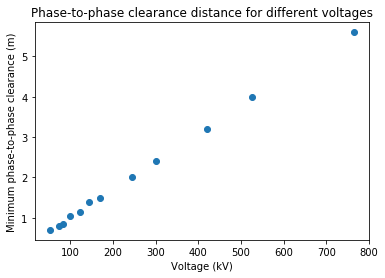

In [18]:
# Phase-phase minimum clearance distances from "Overhead Power Lines - Planning, Design, Construction"
pp_clearance = {52: 0.7, 72.5: 0.8, 82.5: 0.85, 100: 1.05, 123: 1.15, 145: 1.4, 170: 1.5,
               245: 2, 300: 2.4, 420: 3.2, 525: 4, 765: 5.6}

# Plot showing relationship between phase-to-phase clearance distance and line voltage level
f, ax = plt.subplots()
ax.plot(pp_clearance.keys(), pp_clearance.values(), 'o')
ax.set_xlabel('Voltage (kV)')
ax.set_ylabel('Minimum phase-to-phase clearance (m)')
ax.set_title('Phase-to-phase clearance distance for different voltages')
plt.show()

Given the linear relationship between line voltage and minimum clearance distance, linear interpolation is used to obtain minimum clearance distances for lines at intermediate voltage levels.

### Calculations
The following parameters and formulae are used to derive the electrical parameters for transmission lines at different voltage levels.

#### Parameters
Air permitivity: $\varepsilon = 8.854 \times 10^{-12}$ [F/m]

Conductor geometric mean radius (GMR): $D_{s} = 7.1 \times 10^{-3}$ [m]

Conductor resistance: $R = 0.168$ [$\Omega$/km]

System base power: $S_{b} = 100$ [MVA]

AC grid frequency: $f = 50$ [Hz]


#### Formulae
Note: For the per-unit formulae below, equations are used to compute per-unit per-length parameters. In order to compute the per-unit imedance or shunt susceptance for a given transmission line, these quantities must be multiplied by the line's length.

##### Base values
Base impedance: $Z_{base} = \frac{V_{L-L}^{2}}{S_{b}}$

Base admittance: $Y_{base} = \frac{1}{Z_{base}}$

##### Impedance
Inductance: $L = 2 \times 10^{-4} \ln \frac{D_{eq}}{D_{s}}$ [H/km]

Inductive reactance: $X_{L} = 2 \pi f L$ [$\Omega$/km]

Nominal impedance: $X_{nom} = (R + jX_{L})$ [$\Omega$/km]

Per-unit per-length impedance: $X_{pu} = \frac{X_{nom}}{Z_{base}}$ [-/km]


##### Shunt susceptance
Phase to neutral capacitance: $C_{n} = 10^{3} \times \frac{2\pi\varepsilon}{\ln \frac{D_{eq}}{D_{s}}}$ [F/km]

Shunt susceptance: $B_{n} = j 2\pi f C_{n}$ [S/km]

Per-unit per-length shunt susceptance: $B_{pu} = \frac{B_{nom}}{Y_{base}}$ [-/km]

In [19]:
# Conductor and grid parameters
# -----------------------------
# Conductor properties (resistance in Ohms/km, GMR in m)
conductors = {'Pluto' : {'rho': 0.168, 'gmr': 7.1 * 1e-3}, 'Pawpaw': {'rho': 0.0628, 'gmr': 13.67 * 1e-3}}

# Conductors assigned to different voltage levels 
# -----------------------------------------------
# Pawpaw is another conductor type that could be used for high voltage lines. Data for this conductor is
# included here, also from [10], but has not been used in the remainder of the analysis. It may be worth experimenting
# with different conductor types in the future. 

# conductor_assignment = {110: 'Pluto', 132: 'Pluto', 220: 'Pawpaw', 275: 'Pawpaw', 330: 'Pawpaw', 400: 'Pawpaw', 500: 'Pawpaw'}
conductor_assignment = {110: 'Pluto', 132: 'Pluto', 220: 'Pluto', 275: 'Pluto', 330: 'Pluto', 400: 'Pluto', 500: 'Pluto'}

# System frequency [Hz]
f = 50

# System base [MVA]
Sb = 100

# Air permitivity [F/m]
eps = 8.854 * 1e-12


# DataFrame containing electrical parameters
# ------------------------------------------
df_lp = pd.DataFrame(index=gdf_l['CAPACITYKV'].unique())
df_lp.index.name = 'Voltage'
df_lp = df_lp.sort_index()

def get_clearance(row):
    return np.interp(row.name, list(pp_clearance.keys()), list(pp_clearance.values()))

# Minimum clearance between phases based on available data
df_lp['MIN_CLEARANCE'] = np.nan
df_lp['MIN_CLEARANCE'] = df_lp.apply(get_clearance, axis=1)

# Include a safety factor. Assumed design clearance = minimum clearance x 1.5
df_lp['Deq'] = 1.5 * df_lp['MIN_CLEARANCE']

# Base impedance [-]
df_lp['Zbase'] = df_lp.apply(lambda x: (x.name * 1e3)**2 / (Sb * 1e6), axis=1)

# Inductance [H/km]
df_lp['L'] = df_lp.apply(lambda x: 2 * 1e-4 * np.log(x['Deq'] / conductors[conductor_assignment[x.name]]['gmr']), axis=1)

# Inductive reactance [Ohms/km]
df_lp['XL'] = 2 * pi * f * df_lp['L']

# Nominal impedance [Ohms/km]
df_lp['Znom'] = df_lp.apply(lambda x: conductors[conductor_assignment[x.name]]['rho'] + 1j * x['XL'], axis=1)

# Per-unit impedance [-/km]
df_lp['Zpu'] = df_lp['Znom'] / df_lp['Zbase']

# Capacitance [F/km]
df_lp['Cn'] = df_lp.apply(lambda x: 1e3 * ((2 * pi * eps) / np.log(x['Deq'] / conductors[conductor_assignment[x.name]]['gmr'])), axis=1).astype(np.float64)

# Shunt admittance to neutral [S/km]
df_lp['Bnom'] = 1j * 2 * pi * f * df_lp['Cn']

# Shunt admittance to neutral per unit [-/km]
df_lp['Bpu'] = df_lp.apply(lambda x: x['Bnom'] / (1 / x['Zbase']), axis=1)

# Check X/R ratio
print(df_lp.apply(lambda x: np.imag(x['Zpu']) / np.real(x['Zpu']), axis=1))

df_lp

Voltage
110    2.035486
132    2.086199
220    2.228759
275    2.300025
330    2.359425
400    2.421164
500    2.502290
dtype: float64


C:\Users\eee\Anaconda3\envs\nemenv\lib\site-packages\pandas\core\dtypes\cast.py:703: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype)


,MIN_CLEARANCE,Deq,Zbase,L,XL,Znom,Zpu,Cn,Bnom,Bpu
Voltage,,,,,,,,,,
110,1.093478,1.640217,121.00,0.001088,0.341962,(0.168+0.341961687016j),(0.00138842975207+0.00282612964476j),1.022167e-08,3.21123194967e-06j,0.000388559065911j
132,1.252273,1.878409,174.24,0.001116,0.350481,(0.168+0.3504814602j),(0.000964187327824+0.00201148680096j),9.973193e-09,3.13317085099e-06j,0.000545923689076j
220,1.833333,2.750000,484.00,0.001192,0.374431,(0.168+0.374431437117j),(0.000347107438017+0.000773618671729j),9.335271e-09,2.93276201209e-06j,0.00141945681385j
275,2.218182,3.327273,756.25,0.001230,0.386404,(0.168+0.386404175898j),(0.000222148760331+0.000510947670608j),9.046018e-09,2.84189034023e-06j,0.0021491795698j
330,2.600000,3.900000,1089.00,0.001262,0.396383,(0.168+0.396383356088j),(0.000154269972452+0.000363988389429j),8.818279e-09,2.77034410765e-06j,0.00301690473324j
400,3.066667,4.600000,1600.00,0.001295,0.406756,(0.168+0.406755622707j),(0.000105+0.000254222264192j),8.593413e-09,2.69970034489e-06j,0.00431952055183j
500,3.809524,5.714286,2500.00,0.001338,0.420385,(0.168+0.420384668551j),(6.72e-05+0.00016815386742j),8.314811e-09,2.61217493658e-06j,0.00653043734144j


Table of electrical parameters. To be included in manuscript.

In [20]:
# Table of electrical parameters for manuscript
cols = {'MIN_CLEARANCE': 'Min. Clearance', 'Zbase': '$Z_{base}$', 'Deq':'$D_{eq}$', 'L': '$L$', 'XL': '$X_{L}$', 'Znom': '$Z_{nom}$', 'Zpu': '$Z_{pu}$', 'Cn': '$C_{N}$', 'Bnom': '$B_{N}$', 'Bpu': '$B_{pu}$'}
df_lp.rename(columns=cols)[['$Z_{base}$', 'Min. Clearance', '$D_{eq}$', '$L$', '$X_{L}$', '$C_{N}$', '$B_{N}$']].to_csv(os.path.join(output_dir, 'tables', 'electrical_parameters.csv'))

Apply electrical parameters to transmission lines. Compute per-unit impedance and shunt susceptance.

In [21]:
# Per-unit impedance [-]
gdf_l['Z_PU'] = gdf_l.apply(lambda x: x['LINE_LENGTH_KM'] * df_lp.loc[x['CAPACITYKV'], 'Zpu'], axis=1)

# Per-unit shunt susceptance
gdf_l['B_PU'] = gdf_l.apply(lambda x: np.imag(x['LINE_LENGTH_KM'] * df_lp.loc[x['CAPACITYKV'], 'Bpu']), axis=1)

Mark HVDC lines as disconnected from the AC network i.e. `CONNNECTED = False` and add a tag identifying HVDC links i.e. `IS_HVDC = True`.

In [22]:
# Add tag identifying HVDC links
gdf_l['IS_HVDC'] = False

for index, row in df_hvdc.iterrows():
    # For each HVDC line, lookup IDs of transmission lines
    mask = gdf_l['FROM_NODE'].isin([row['FROM_NODE'], row['TO_NODE']]) & gdf_l['TO_NODE'].isin([row['FROM_NODE'], row['TO_NODE']])
    
    # Set connected status to False for HVDC lines (effectively removes them from the dataset) and add a tag identifying these lines as HVDC links
    gdf_l.loc[mask, 'CONNECTED'] = False
    gdf_l.loc[mask, 'IS_HVDC'] = True

Table of total line lengths by voltage level.

In [23]:
mask = (gdf_l['CONNECTED'] == True) | (gdf_l['IS_HVDC'] == True)
edge_lengths = gdf_l[mask].groupby('CAPACITYKV')['LINE_LENGTH_KM'].sum().to_frame().rename(columns={'LINE_LENGTH_KM': 'Line length [km]'}).round(1)
edge_lengths.index.name = 'Voltage [kV]'
edge_lengths.to_csv(os.path.join(output_dir, 'tables', 'total_edge_lengths.csv'))

Find number of identical lines connecting the same nodes. This is accomplished by hashing tuples defining the paths for each line (lines with identical paths will have the same hash value). Note that lines can follow the same path, but due to different line-to-line voltages have differnt per-unit impedances. For this reason lines are filtered by the value of their hashed coordinates and per-unit impedance. It is not possible to directly apply 'groupby' operations using complex numbers. For this reason complex impedances are also hashed, allowing a  mechanism by which to apply a filter based on the path of a line and its complex per-unit impedance.

In [24]:
# Hash coordinates defining the path for each line
gdf_l['COORDINATES_HASH'] = gdf_l.apply(lambda x: hash(tuple(x['COORDINATES'])), axis=1)

# Hash complex impedances
gdf_l['Z_PU_HASH'] = gdf_l.apply(lambda x: hash(x['Z_PU']), axis=1)

def get_number_of_identical_lines(row):
    """Find number of identical lines joining two nodes"""
    
    # Group lines by the hash of the path and hash of complex impedance values
    gdf = gdf_l.groupby(['COORDINATES_HASH', 'Z_PU_HASH']).size().reset_index().rename(columns={0: 'NUMLINES'})
    
    # Lookup and return the corresponding number of lines.
    mask = (gdf['COORDINATES_HASH'] == row['COORDINATES_HASH']) & (gdf['Z_PU_HASH'] == row['Z_PU_HASH'])
    
    return gdf.loc[mask, 'NUMLINES'].values[0]
gdf_l['NUM_LINES'] = gdf_l.apply(get_number_of_identical_lines, axis=1)

# Drop duplicated lines (those with the same path and complex impedance)
gdf_l.drop_duplicates(subset=['COORDINATES_HASH', 'Z_PU_HASH'], inplace=True)

# Per-unit resistance
gdf_l['R_PU'] = gdf_l['Z_PU'].map(lambda x: np.real(x))

# Per-unit susceptance
gdf_l['X_PU'] = gdf_l['Z_PU'].map(lambda x: np.imag(x))

## Allocate demand to nodes
Limited data exists regarding the spatial distribution of electricity demand within the NEM, with only aggregate values for demand in each NEM region provided by AEMO. In this analysis we adopt a similar approach to that used in [12] and [13] to disaggregate demand, assigning a fixed proportion of regional demand to each node based on population. ABS data for population by Statistical Area Level 2 (SA2) are used [5]. Records in kml files define the geographic boundaries of each SA2 area, along with each area's population. We then construct a Voronoi tesselation based on nodes in the connected network. The polygons arising from the tessellation are used to approximate the demand area which each node serves. We then approximate the population within each Voronoi polygon, and ultimately express this population as a fraction of total regional population, with this statistic used as a proxy for the proportion of regional demand consumed at a given node.

The Voronoi tessellation is overlayed with SA2 area polygons in order to approximate the total population within each Voronoi polygon. For each Voronoi polygon, the SA2 polygons with which it intersects are found, along with the area of intersection. Assuming that the population in each SA2 area is geospatially uniformly distributed, the proportion of intersected SA2 area can be used to approximate the proporion of the SA2 area's population that resides within the Voronoi polygon. Aggregating individual population contributions from each intersected SA2 area yields the total population within each Voronoi polygon, which is equivalent to the total population assigned to each node. Each node's population is then be expressed relative to the total population of the NEM region in which the node resides, which is used as a proxy for the proportion of regional demand consumed at a given node.

The steps taken to allocate the proportion of regional demand to each node are as follows:
1. Parse SA2 population data.
2. Assign NEM region codes to SA2 areas.
4. Construct Voronoi tessellation
5. For each Voronoi polygon:
    * find all SA2 areas intersecting with the Voronoi polygon;
    * for each SA2 area intersecting the Voronoi polygon:
        * compute the area of intersection between the SA2 area and the Voronoi polygon. Express this area as a fraction total SA2 area.
        * Multiply the fraction of SA2 area intersected by the total population within that SA2 area.
    * aggregate population contributions from each SA2 area;
    * divide the aggregate Voronoi polygon population by the total population of the region in which the polygon resides (yielding the proportion of regional population allocated to each node, which is used as a proxy for the proportion of regional demand consumed at each node).

### Parse SA2 population data
First, convert kml data to geojson format and then load into a geodataframe. SA2 boundaries are sometimes represented as 'Geometry Collections' which must be converted to MultiPolygon objects to facilitate the use of spatial join operations. State names are then derived based on the first digit of each record's 'SA2_5DIGITCODE_2011'. NEM region codes are then assigned using these state names. SA2 area centroids are then computed, and the relationships between nodes and SA2 areas established.

In [25]:
# ABS - Statistical Area Level 2 (SA2) data. Population by SA2 zone.
SA2_dir = os.path.join(data_dir, 'ABS', '32180 SA2 ERP 2015', 'doc.kml')

# Convert kml to geojson
kml2geojson.main.convert(SA2_dir, os.path.join(output_dir, 'kml_to_geojson', 'SA2_population_data'))

# Import geojson into geopandas frame
gdf_SA2 = gp.read_file(os.path.join(output_dir, 'kml_to_geojson', 'SA2_population_data', 'doc.geojson'))
gdf_SA2['Population_2015'] = pd.to_numeric(gdf_SA2['Population_2015'])
gdf_SA2['SA2_5DIGITCODE_2011'] = pd.to_numeric(gdf_SA2['SA2_5DIGITCODE_2011'])

# Change coordinate reference system to EPSG 4283 (same as node and line GeoDataFrames)
gdf_SA2 = gdf_SA2.to_crs(gdf_n.crs)

# Convert to multi-polygon if a geometry collection
def convert_polygons(row):
    if isinstance(row, shapely.geometry.collection.GeometryCollection):
        return MultiPolygon(row)
    else:
        return row
gdf_SA2['geometry'] = gdf_SA2['geometry'].map(convert_polygons)

# Mapping between first SA2 5-digit code number and states
SA2_states = {'1': 'New South Wales', '2': 'Victoria', '3': 'Queensland', '4': 'South Australia',
              '5': 'Western Australia', '6': 'Tasmania', '7': 'Northern Territory',
              '8': 'Australian Capital Territory', '9': 'Other'}

# Assign state based on SA2 code
gdf_SA2['STATE_NAME'] = gdf_SA2['SA2_5DIGITCODE_2011'].map(lambda x: SA2_states[str(x)[0]])

# Drop zones in Northern Territory, Western Australia, and Other
gdf_SA2 = gdf_SA2[~gdf_SA2['STATE_NAME'].isin(['Northern Territory', 'Western Australia', 'Other'])]

# Assign NEM region code to each SA2 area based on the state in which the SA2 area is located
gdf_SA2['NEM_REGION'] = gdf_SA2['STATE_NAME'].map(lambda x: nem_regions[x])

### Voronoi tessellation
Using connected network nodes, a Veronoi tessellation for Australia is constructed. Polygons arising from the tessellation will be used as a proxy for the area that each node serves demand to. The intersection between these polygons and SA2 areas will be used to calculate the approximate population within each Voronoi polygon. Note that the standard SciPy Voronoi tessellation module does not provide methods that bound infinite regions. Credit to Pauli Virtanen for this function [https://gist.github.com/pv/8036995](https://gist.github.com/pv/8036995) which does bound infinite regions, and has been used in the analysis below.

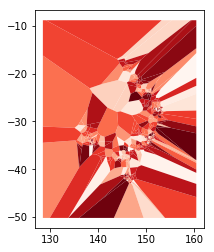

In [26]:
# Connected nodes to be used to construct Voronoi tessellation
mask = gdf_n['CONNECTED'] == True
vor = Voronoi(list(gdf_n.loc[mask, 'geometry'].map(lambda x: (x.x, x.y))))

# Regions and vertices for Voronoi tesselation with finite polygons
regions, vertices = voronoi_finite_polygons_2d(vor)

# Min and max coordinates for plot
min_x = vor.min_bound[0] - 7
max_x = vor.max_bound[0] + 7
min_y = vor.min_bound[1] - 7
max_y = vor.max_bound[1] + 7

# Get bounded vertices
mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

# Bounding box
bbox = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

polygons = []
for region in regions:
    polygon = vertices[region]

    # Get bounded polygon
    poly = Polygon(polygon)
    poly = poly.intersection(bbox)
    poly_boundary = [p for p in poly.exterior.coords]
    polygons.append(Polygon(poly_boundary))

# GeoDataFrame containing Voronoi polygons
gdf_v = gp.GeoDataFrame(data=polygons, columns=['geometry'])
gdf_v.crs = gdf_n.crs
gdf_v.plot(cmap='Reds')

Assign population to each node.

In [27]:
def assign_demand_to_node_voronoi(gdf_n):
    """
    Assign demand to nodes based on Voronoi tessellation overlap with SA2 areas.
    
    Parameters
    ----------
    gdf_n : GeoDataFrame
        Node information
    
    Returns
    -------
    gdf_vor : GeoDataFrame
        Voronoi polygons with assigned population and proportion of regional demand allocation    
    
    gdf_u : GeoDataFrame
        Unary union polygons of all SA2 areas. Used will be used to overlay over Veronoi polygons
    """
    
    # Remove z-coordinate
    def remove_z(row):
        'Remove z-coordinates if they exist. Buffer polygon to reduced likelihood of errors'

        # Get polygon coordinates and only retain x and y
        p = Polygon([(x, y) for x, y, z in row['geometry'].exterior.coords])

        # Buffer with zero width to reduce chance of errors
        p_buff = p.buffer(0)
        return p_buff

    # Explode multipolygons
    gdf_p = gp.GeoDataFrame(gdf_SA2['geometry'].explode().reset_index())

    # Remove z-coordinates
    gdf_p['geometry'] = gdf_p.apply(remove_z, axis=1)

    # Unary union of exploded polygons
    gdf_u = gp.GeoDataFrame(data=list(gdf_p.unary_union), columns=['geometry'])

    # Dissolve by SA2 area ID
    gdf_pd = gdf_p.dissolve(by='level_0')
    gdf_pd.crs = gdf_SA2.crs

    # Find intersection with Voronoi cells
    gdf_i = gp.sjoin(gdf_v, gdf_pd, how='left', op='intersects').drop('level_1', axis=1)   
    gdf_i = gdf_i.rename(columns={'index_right': 'SA2_ID'})

    # Intersection between Voronoi polygons and SA2 areas
    gdf_i['intersection_area'] = gdf_i.apply(lambda x: x['geometry'].intersection(gdf_pd.loc[x['SA2_ID'], 'geometry']).area, axis=1)

    # Intersection population
    gdf_i['population'] = gdf_i.apply(lambda x: (x['intersection_area'] / gdf_pd.loc[x['SA2_ID'], 'geometry'].area) * gdf_SA2.loc[x['SA2_ID'], 'Population_2015'], axis=1)

    # Index is Voronoi polygon ID
    gdf_i.index.name = 'voronoi_ID'

    # Population in each Voronoi polygon
    gdf_vor = gdf_i.dissolve(by='voronoi_ID', aggfunc='sum').drop(['SA2_ID', 'intersection_area'], axis=1).rename(columns={'intersection_population': 'population'})

    # Assign node to each Voronoi polygon
    mask = gdf_n['CONNECTED'] == True
    gdf_vor = gp.sjoin(gdf_vor, gdf_n.loc[mask, ['geometry', 'NEM_REGION']], how='left', op='contains').rename(columns={'index_right': 'NODE_ID'})

    # Compupte proportion of regional population assigned to each node
    gdf_vor['PROP_REG_D_VOR'] = gdf_vor.apply(lambda x: x['population'] / gdf_vor.groupby('NEM_REGION')['population'].sum().loc[x['NEM_REGION']], axis=1)

    # Check that sum of regional load proportions allocated to nodes = 1 for each NEM region
    print(gdf_vor.groupby('NEM_REGION')['PROP_REG_D_VOR'].sum())
    
    return gdf_vor, gdf_u
# Voronoi polygons with assigned populations and proportions of regional demand, and GeoDataFrame containing unary_union polygons for all SA2 areas
gdf_vor, gdf_u = assign_demand_to_node_voronoi(gdf_n)

# Join demand allocations to node GeoDataFrame
gdf_n = gdf_n.join(gdf_vor.set_index('NODE_ID')['PROP_REG_D_VOR'], how='left')

NEM_REGION
NSW1    1.0
QLD1    1.0
SA1     1.0
TAS1    1.0
VIC1    1.0
Name: PROP_REG_D_VOR, dtype: float64


## Save data

In [28]:
# Network edges
# -------------
# Only keep transmission lines in the connected network
mask = gdf_l['CONNECTED'] == True
gdf_l.loc[mask, ['name', 'FROM_NODE', 'TO_NODE', 'R_PU', 'X_PU', 'B_PU', 'NUM_LINES', 'LINE_LENGTH_KM', 'CAPACITYKV']].rename(columns={'name': 'NAME', 'LINE_LENGTH_KM': 'LENGTH_KM', 'CAPACITYKV': 'VOLTAGE_KV'}).to_csv(os.path.join(output_dir, 'network_edges.csv'))


# AC interconnectors and HVDC links
# ---------------------------------
# HVDC links
df_hvdc[['FROM_NODE', 'TO_NODE', 'FORWARD_LIMIT_MW', 'REVERSE_LIMIT_MW', 'VOLTAGE_KV']].to_csv(os.path.join(output_dir, 'network_hvdc_links.csv'))

# AC interconnector links
df_ac_i.to_csv(os.path.join(output_dir, 'network_ac_interconnector_links.csv'))

# AC interconnector flow limits
df_ac_ilim.to_csv(os.path.join(output_dir, 'network_ac_interconnector_flow_limits.csv'))


# Nodes
# -----
# Extract latitude and longitdue values for each node
gdf_n['LATITUDE'] = gdf_n.apply(lambda x: x['geometry'].y, axis=1)
gdf_n['LONGITUDE'] = gdf_n.apply(lambda x: x['geometry'].x, axis=1)

# Only keep nodes in the connected network
mask = gdf_n['CONNECTED'] == True

# Use Voronoi demand allocations
gdf_n = gdf_n.rename(columns={'PROP_REG_D_VOR': 'PROP_REG_D'})

# Write to csv file
gdf_n.loc[mask, ['STATE_NAME', 'NEM_REGION', 'NEM_ZONE', 'VOLTAGE_KV', 'RRN', 'PROP_REG_D', 'LATITUDE', 'LONGITUDE']].to_csv(os.path.join(output_dir, 'network_nodes.csv'))


# Power stations allocated - nodes allocation
# -------------------------------------------
# Extract latitude and longitdue values for each node
gdf_p['LATITUDE'] = gdf_p.apply(lambda x: x['geometry'].y, axis=1)
gdf_p['LONGITUDE'] = gdf_p.apply(lambda x: x['geometry'].x, axis=1)

# Only consider connected network elements
mask = gdf_p['CONNECTED'] == True

# Rename columns and write to csv file
gdf_p.loc[mask, ['id', 'name', 'PRIMARYFUELTYPE', 'NEAREST_NODE', 'NEAREST_NODE_DISTANCE_KM', 'LATITUDE', 'LONGITUDE']].rename(columns={'id':'PLACEMARK_ID', 'name': 'NAME'}).to_csv(os.path.join(output_dir, 'network_power_stations-nodes.csv'))


# Save GeoDataFrames
# ------------------
# Nodes
with open(os.path.join(output_dir, 'gdf_n.pickle'), 'wb') as f: pickle.dump(gdf_n, f)

# Transmission lines
with open(os.path.join(output_dir, 'gdf_l.pickle'), 'wb') as f: pickle.dump(gdf_l, f)

# Power stations
with open(os.path.join(output_dir, 'gdf_s.pickle'), 'wb') as f: pickle.dump(gdf_s, f)

# Substations
with open(os.path.join(output_dir, 'gdf_p.pickle'), 'wb') as f: pickle.dump(gdf_p, f)

# Voronoi polygons
with open(os.path.join(output_dir, 'gdf_vor.pickle'), 'wb') as f: pickle.dump(gdf_vor, f)
    
# SA2 areas
with open(os.path.join(output_dir, 'gdf_SA2.pickle'), 'wb') as f: pickle.dump(gdf_SA2, f)
    
# Unary union polygons for SA2 areas
with open(os.path.join(output_dir, 'gdf_u.pickle'), 'wb') as f: pickle.dump(gdf_u, f)

## References
[1] - Commonwealth of Australia (Geoscience Australia), Electricity Transmission Lines (2017), at http://pid.geoscience.gov.au/dataset/ga/83105

[2] - Commonwealth of Australia (Geoscience Australia), Electricity Transmission Substations (2017), at http://pid.geoscience.gov.au/dataset/ga/83173

[3] - Commonwealth of Australia (Geoscience Australia), Power Stations (2017), at http://pid.geoscience.gov.au/dataset/ga/82326

[4] - Australian Bureau of Statistics. Local Government Areas ASGS Ed 2016 Digital Boundaries in
ESRI Shapeﬁle Format. (2016). at http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202016?OpenDocument

[5] - Australian Bureau of Statistics. Regional Population Growth, Australia, 2014-15. (2016). at
http://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/3218.02014-15?OpenDocument

[6] - Australian Energy Markets Operator. Market Modelling Methodology and Input Assumptions - For Planning the National Electricity Market and Eastern and South-eastern Gas Systems. (AEMO, 2016). at https://www.aemo.com.au/-/media/Files/Electricity/NEM/Planning_and_Forecasting/NTNDP/2016/Dec/Market-Modelling-Methodology-And-Input-Assumptions.pdf

[7] - Australian Energy Markets Operator. Interconnector Capabilities for the National Electricity Market. (2017). at https://www.aemo.com.au/-/media/Files/Electricity/NEM/Security_and_Reliability/Congestion-Information/2017/Interconnector-Capabilities.pdf

[8] - Glover, J. D., Sarma, M. S. & Overbye, T. J. Power System Analysis and Design, Fifth Edition (Cengage Learning, 2011).

[9] -  Ausgrid. NS220 Overhead Design Manual. (Ausgrid, 2016). at https://www.ausgrid.com.au/-/media/Files/Network/Documents/NS-and-NUS/NS220.pdf

[10] - Prysmian. Airborne - bare overhead conductors perfectly adapted to the Australian sky. (Prysmian, 2015). at http://www.prysmiancable.com.au/wp-content/uploads/2014/12/Prysmian_BareOverheadConductors_2015-10_LOWRES.pdf

[11] - Kiessling, F., Nefzger, P., Nolasco, J. F. & Kaintzyk, U. Overhead Power Lines: Planning, Design, Construction. pg. 57 (Springer, 2014).

[12] - Zhou, Q. & Bialek, J. W. Approximate model of european interconnected system as a benchmark system to study eﬀects of cross-border trades. IEEE Trans. Power Syst. 20, 782–788 (2005).

[13] - Jensen, T. V. & Pinson, P. RE-Europe, A large-scale dataset for modeling a highly renewable European electricity system. Sci. Data 4, 170175 (2017).